In [ ]:
import scanpy as sc
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score as sil, mean_squared_error
from anndata import AnnData
import seaborn as sns
from scipy.stats import pearsonr, kendalltau, spearmanr
from tqdm.notebook import tqdm

In [3]:
work_dir = "" # Path to the directory where the repository was cloned
os.chdir(work_dir)

In [4]:

data_directory = "./final_data/csv"
noise_dir = f"{data_directory}/noise_filt"
true_dir = f"{data_directory}/true_filt"

filenames = os.listdir(noise_dir)

data_directory_var = "./final_data/csv_mostvar"
noise_dir_var = f"{data_directory_var}/noise_filt"
true_dir_var = f"{data_directory_var}/true_filt"

filenames_var = os.listdir(noise_dir_var)
filenames = [x for x in filenames + filenames_var if "UMI" in x]

# Retrieve the denoisers list
denoisers = os.listdir(data_directory)
denoisers = [x.split("_")[1] for 
             x 
             in 
             denoisers 
             if ("denoised" in x) and ("scRecover" not in x)]

In [5]:
# Labels that will appear in figures
labels_den = ['ALRA',
             'bayNorm',
             'DCA',
             'DeepImpute',
             'DrImpute',
             'ENHANCE',
             'kNN-smoothing',
             'MAGIC',
             'SAVER',
             'SAVER-X',
             'scImpute',
             'scRMD',
             'VIPER']

## Performances on cell-to-cell similarities

In [6]:
def compute_silhouette(adata, key, figures_dir, figure_name):
    sc.pp.log1p(adata)
    num_pca=50
    adata.layers['unscaled'] = adata.X.copy()
    sc.pp.scale(adata)
    sc.tl.pca(adata, n_comps=num_pca, svd_solver="arpack", random_state=0)
    sc.pp.neighbors(adata, n_pcs = num_pca, n_neighbors=20, random_state=0) 
    sc.tl.umap(adata, random_state=0)
    
    p = sc.pl.pca(adata, color=key, return_fig=True, title = f"{figure_name} PCA")
    p.savefig(f"{figures_dir}/{figure_name}_pca.png", 
              dpi=300,
             bbox_inches="tight")
    plt.close(p)
    p = sc.pl.umap(adata, color=key, return_fig=True, title = f"{figure_name} UMAP")
    p.savefig(f"{figures_dir}/{figure_name}_umap.png", 
              dpi=300,
             bbox_inches="tight")
    plt.close(p)
    sil_orig = sil(adata.layers['unscaled'], labels=adata.obs[key])
    return sil_orig

In [5]:
def read_normalize_denoised(d, data_dir,experiment_name):
    if d== "saverx":
        # SAVER-X leaves some values to nan, we set them to 0
        adata = pd.read_csv(f"{data_dir}/denoised_{d}/{experiment_name}_denoised_{d}.csv", na_values='NA')
        print(f"SAVERX: number of nan: {sum(sum(np.isnan(adata.values)))} out of {adata.shape[0] * adata.shape[1]}")
        adata = adata.fillna(0)
        adata = AnnData(adata)
        adata = adata.transpose()
    else:
        adata = sc.read_csv(f"{data_dir}/denoised_{d}/{experiment_name}_denoised_{d}.csv")
        adata = adata.transpose()
        
    # ALRA and DrImpute give log-normalized data 
    if d in ["DRimpute", 'ALRA']:
        print("Normalizing data for DRIMPUTE ALRA")
        adata.X = np.expm1(adata.X)
    # Extract the information about cell sub-population. Each cell has an ID like cell2_p1, where the last two characters
    # correspond to its sub-population
    pop = [x[-2:] for x in adata.obs_names]  
    pop = [x if x not in ['p4','p5'] else 'p4' for x in pop]
    adata.obs['pop'] = pop
    sc.pp.normalize_total(adata, target_sum=1e4)
    
    return adata

In [8]:
os.makedirs("./final_data/figures", exist_ok=True)

In [ ]:
"""
Instantiate the list that will contain results:

    one line per setting (i.e. ground truth, before denoising and each denoised version)
    In each line we have the mean silhouette coefficient of the cells in the corresponding dataset, calculated using the 
    ground truth information about cell type.

"""

results = []

for f in tqdm(filenames):
    # Load noise
    experiment_name = re.sub("_noise.csv$","", f)
    noise_directory_f = noise_dir_var if "genes" in f else noise_dir
    
    adata = sc.read_csv(f"{noise_directory_f}/{f}")
    adata = adata.transpose()
    
    print(f"Just read noise: shape: {adata.shape}")
    npop = 5 if "5_pop" in experiment_name else 3
    pop = [x[-2:] for x in adata.obs_names]  
    pop = [x if x not in ['p4','p5'] else 'p4' for x in pop]
    adata.obs['pop'] = pop
    ncells = adata.shape[0]
    ngenes = adata.shape[1]
    print(f"Dimensions: {ncells} cells {ngenes} genes")
    zeros = sum(sum(adata.X == 0)) / (adata.shape[0] * adata.shape[1])
    
    sc.pp.normalize_total(adata, target_sum=1e4)
    
    sil_orig = compute_silhouette(adata,
                                  key = 'pop', 
                                  figures_dir="./final_data/figures",
                                  figure_name=f"{experiment_name}_noise")
    results.append([experiment_name, 
                    "before denoising", 
                    ncells, 
                    ngenes, 
                    zeros, 
                    npop, 
                    sil_orig])
    # Load ground truth
    true_directory_f = true_dir_var if "genes" in f else true_dir
    adata = sc.read_csv(f"{true_directory_f}/{experiment_name}_true.csv")
    adata = adata.transpose()
    print(f"Just read gt: shape: {adata.shape}")
    adata.obs['pop'] = pop
    ncells = adata.shape[0]
    ngenes = adata.shape[1]
    npop = 5 if "5_pop" in experiment_name else 3

    zeros = sum(sum(adata.X == 0)) / (adata.shape[0] * adata.shape[1])

    sc.pp.normalize_total(adata, target_sum=1e4)

    
    sil_orig = compute_silhouette(adata, 
                                  key = 'pop', 
                                  figures_dir="./final_data/figures", 
                                  figure_name=f"{experiment_name}_true")
    results.append([experiment_name, 
                    "Ground truth", 
                    ncells, 
                    ngenes, 
                    zeros, 
                    npop, 
                    sil_orig])
    # Now load all denoised
    data_dir = data_directory_var if "genes" in f else data_directory
    for d in tqdm(denoisers):
        print(f"Doing {d}")
        adata = read_normalize_denoised(d, experiment_name=experiment_name, data_dir=data_dir)

        zeros = sum(sum(adata.X == 0)) / (adata.shape[0] * adata.shape[1])
        
        sil_orig = compute_silhouette(adata,
                                      key = 'pop', 
                                      figures_dir="./final_data/figures", 
                                      figure_name=f"{experiment_name}_{d}")
        results.append([experiment_name, 
                        d, 
                        ncells, 
                        ngenes, 
                        zeros, 
                        npop, 
                        sil_orig])


In [14]:
df_sil = pd.DataFrame(results, columns = ['experiment', 
                                         'algorithm', 
                                         "n_cells", 
                                         "n_genes", 
                                         "perc_zeros", 
                                         "n_pop", 
                                         "silhouette gene expression"])

## Compute silhouette delta

In [7]:
# Cast columns to float
cast_types = {x : 'float' for x in df_sil.columns if x not in ['algorithm', 'experiment']}
df_sil = df_sil.astype(cast_types)

In [8]:
n_cells = [int(x) if x == 100 else 3000 for x in df_sil['n_cells'].values]
df_sil['n_cells'] = n_cells

n_genes = [int(x) if x <= 5000 else 10000 for x in df_sil['n_genes'].values]
df_sil['n_genes'] = n_genes

In [9]:
# First retrieve the silhouette value of each dataset with noise
experiments = [re.sub("_noise.csv$","", f) for f in filenames]
sil_orig_before = {}
for e in experiments:
    tmp = df_sil[(df_sil["experiment"] == e) & (df_sil["algorithm"] == "before denoising")]
    sil_orig_before[e] = list(tmp["silhouette gene expression"])[0]

In [ ]:
# Now compute the difference silhouette after - silhouette before
diff_performances = df_sil[df_sil["algorithm"] != "before denoising"] 

diff_orig = []
for i in range(diff_performances.shape[0]):
    temp = diff_performances.iloc[i,:]
    e = temp["experiment"]
    diff_orig.append(temp["silhouette gene expression"] - sil_orig_before[e])

diff_performances["Silhouette gene expression delta"] = diff_orig

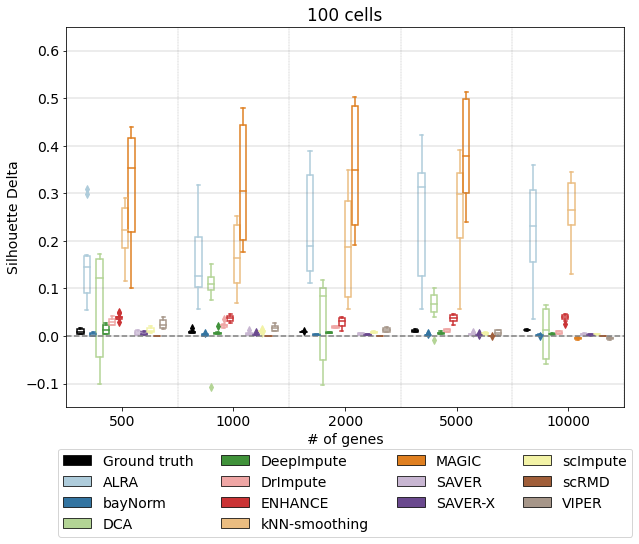

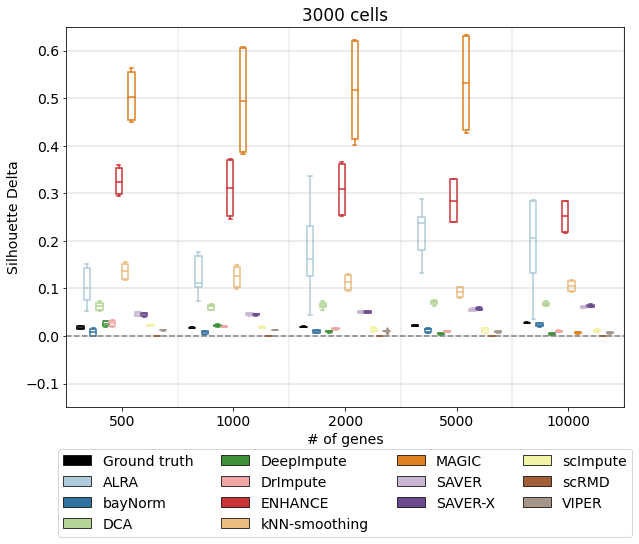

In [11]:
plt.rcParams.update({'font.size': 14})

pal = sns.color_palette('Paired', 12)
pal = list(pal) + [(171/255,149/255,132/255)]
for n in [100, 3000]:
    fig, ax1 = plt.subplots(1,1,figsize=(10, 7))
    sns.boxplot(x = "n_genes", 
                y="Silhouette gene expression delta", 
                hue = "algorithm", 
                data=diff_performances[diff_performances['n_cells'] == n], 
                hue_order=['Ground truth'] + denoisers,
                ax=ax1,
               palette=[(0,0,0)] + list(pal))
    
    L = ax1.legend(loc=9, ncol=4, bbox_to_anchor=(0.5, -0.09))
    ax1.axhline(y=0, color="grey", linestyle="--")
    ax1.set_title(f"{n} cells")
    ax1.set_xlabel("# of genes")
    ax1.set_ylabel("Silhouette Delta")
    plt.ylim(bottom=-0.15, top=0.65)
    for x in np.arange(0.5, 5):
        ax1.axvline(x=x, color="grey", linestyle="--", linewidth=0.3)

    # Color the box borders
    for i,artist in enumerate(ax1.artists):
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        for j in range(i*6,i*6+6):
            line = ax1.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)
            
    # Rename labels in legend
    for i,d in enumerate(labels_den):
        L.get_texts()[i+1].set_text(d)
        
    plt.grid(True, axis='y', color='grey', linewidth=0.3)

    plt.show()

## Correlation performances

In [ ]:
"""
Instantiate the list that will contain results:
    one line per setting (i.e. before denoising and each denoised version)
    In each line we have:   mean correlation of each single cell with the ground truth
                            mean correlation of those entries that are 0 in the noise profile
                            (Note that for lines corresponding to noisy datasets we put -10 for this, as we do not use it in
                            the computation of results)

"""
results_corr = []

for f in tqdm(filenames):
    # Load noise
    experiment_name = re.sub("_noise.csv$","", f)
    
    noise_directory_f = noise_dir_var if "genes" in f else noise_dir
    adata_noise = sc.read_csv(f"{noise_directory_f}/{f}")
    adata_noise = adata_noise.transpose()
    
    adata_noise.var.index = [x.replace("_","-") for x in adata_noise.var.index]
    npop = 5 if "5_pop" in experiment_name else 3
    
    ncells = adata_noise.shape[0]
    ngenes = adata_noise.shape[1]
    zeros = sum(sum(adata_noise.X == 0)) / (adata_noise.shape[0] * adata_noise.shape[1])
    
    sc.pp.normalize_total(adata_noise, target_sum=1e4)
    sc.pp.log1p(adata_noise)
    
    # Load ground truth    
    true_directory_f = true_dir_var if "genes" in f else true_dir
    adata_true = sc.read_csv(f"{true_directory_f}/{experiment_name}_true.csv")
    adata_true = adata_true.transpose()
    adata_true.var.index = [x.replace("_","-") for x in adata_true.var.index]
    ncells = adata_true.shape[0]
    ngenes = adata_true.shape[1]
    npop = 5 if "5_pop" in experiment_name else 3

    sc.pp.normalize_total(adata_true, target_sum=1e4)
    sc.pp.log1p(adata_true)
    
    cell_corr_sper = np.mean([spearmanr(adata_true.X[c,:],adata_noise.X[c,:])[0] for c in range(adata_true.shape[0])])

    results_corr.append([experiment_name, 
                        "before denoising", 
                        ncells, 
                        ngenes, 
                        zeros, 
                        npop, 
                        cell_corr_sper,
                        -10])

    # Now load all denoised
    data_dir = data_directory_var if "genes" in f else data_directory
    for d in tqdm(denoisers):
        adata = read_normalize_denoised(d, experiment_name=experiment_name, data_dir=data_dir)
        sc.pp.log1p(adata)
        zeros = sum(sum(adata.X == 0)) / (adata.shape[0] * adata.shape[1])
        cell_corr_zeros = []
        for c in range(adata.shape[0]):
            mask = adata_noise.X[c] == 0
            cell_corr_zeros.append(spearmanr(adata_true.X[c,mask],adata.X[c,mask])[0])

        cell_corr_zeros = np.mean(np.array(cell_corr_zeros)[~np.isnan(cell_corr_zeros)])

        cell_corr_sper = np.mean([spearmanr(adata_true.X[c,:],adata.X[c,:])[0] for c in range(adata_true.shape[0])])

        results_corr.append([experiment_name, 
                            d, 
                            ncells, 
                            ngenes, 
                            zeros, 
                            npop, 
                            cell_corr_sper,
                            cell_corr_zeros])


In [7]:
df_corr = pd.DataFrame(results_corr, columns = ['experiment', 
                                                 'algorithm', 
                                                 "n_cells", 
                                                 "n_genes", 
                                                 "perc_zeros", 
                                                 "n_pop", 
                                                "cell-cell correlation sper",
                                               "cell-cell correlation (zeros)"])

## With the pandas with results

In [13]:
n_cells = [x if x == 100 else 3000 for x in df_corr['n_cells'].values]
df_corr['n_cells'] = n_cells
n_genes = [x if x <= 5000 else 10000 for x in df_corr['n_genes'].values]
df_corr['n_genes'] = n_genes

In [ ]:
experiments = [re.sub("_noise.csv$","", f) for f in filenames]
# For each noisy dataset retrieve the mean Spearman correlation between its cells and the corresponding ground truth profiles
corr_sper_before = {}

for e in experiments:
    tmp = df_corr[(df_corr["experiment"] == e) & (df_corr["algorithm"] == "before denoising")]
    corr_sper_before[e] = list(tmp["cell-cell correlation sper"])[0]

# Now compute the difference between correlation after denoising and correlation before    
diff_performances = df_corr[df_corr["algorithm"] != "before denoising"] 
diff_corr_sper = []

for i in range(diff_performances.shape[0]):
    temp = diff_performances.iloc[i,:]
    e = temp["experiment"]
    diff_corr_sper.append(temp["cell-cell correlation sper"] - corr_sper_before[e])

diff_performances["Spearman delta"] = diff_corr_sper


## Visualize performances on the recovery of lost information

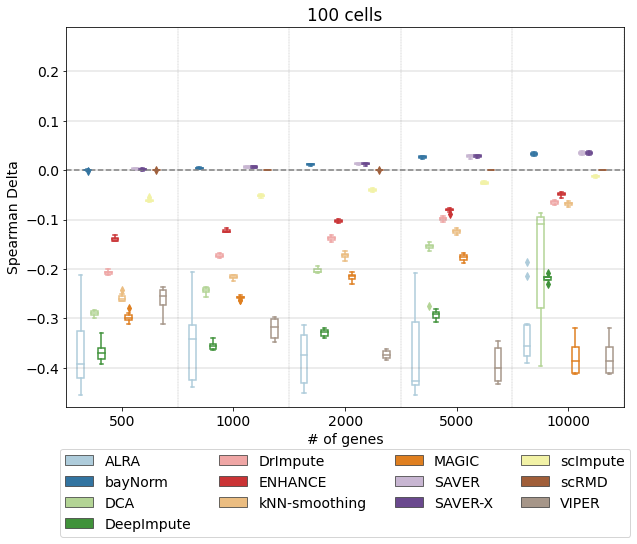

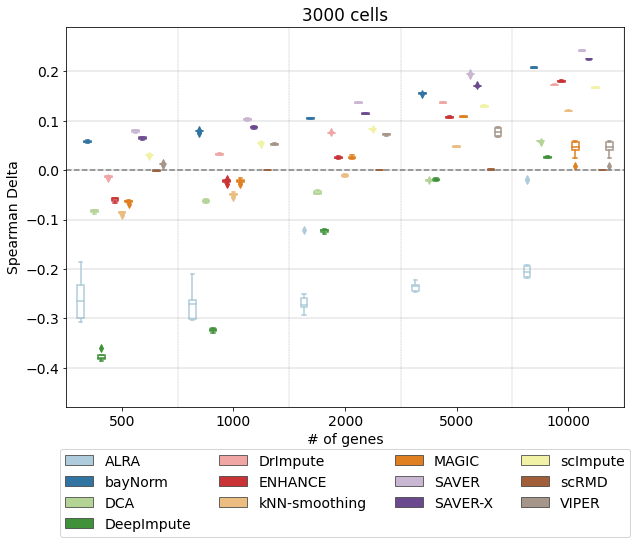

In [15]:
plt.rcParams.update({'font.size': 14})
nc = [100,3000]

for n in nc:
    fig, ax1 = plt.subplots(1,1,figsize=(10, 7))

    pal = sns.color_palette('Paired', 12)
    pal = list(pal) + [(171/255,149/255,132/255)]

    sns.boxplot(x = "n_genes", 
                y="Spearman delta", 
                hue = "algorithm", 
                data=diff_performances[diff_performances['n_cells'] == n], 
                hue_order= denoisers,
                ax=ax1,
               palette=pal)
    L = ax1.legend(loc=9, ncol=4, bbox_to_anchor=(0.5, -0.09))
    ax1.axhline(y=0, color="grey", linestyle="--")
    ax1.set_title(f"{n} cells")
    ax1.set_xlabel("# of genes")
    ax1.set_ylabel("Spearman Delta")

    ax1.set_ylim(top= 0.29, bottom = -0.48)

    for x in np.arange(0.5, 5):
        ax1.axvline(x=x, color="grey", linestyle="--", linewidth=0.3)

    # Color the edges of the boxes
    for i,artist in enumerate(ax1.artists):
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        for j in range(i*6,i*6+6):
            line = ax1.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)
            
    # Rename labels in legend
    for i,d in enumerate(labels_den):
        L.get_texts()[i].set_text(d)
        
    plt.grid(True, axis='y', color='grey', linewidth=0.3)#style='--')
    plt.show()
        



## Visualize performances on imputation

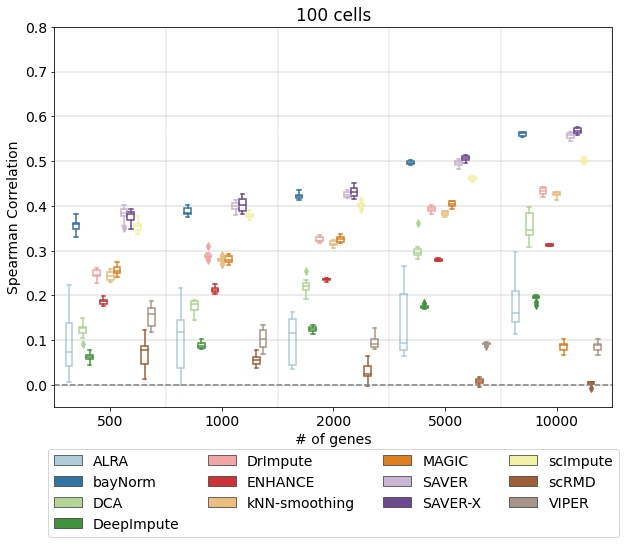

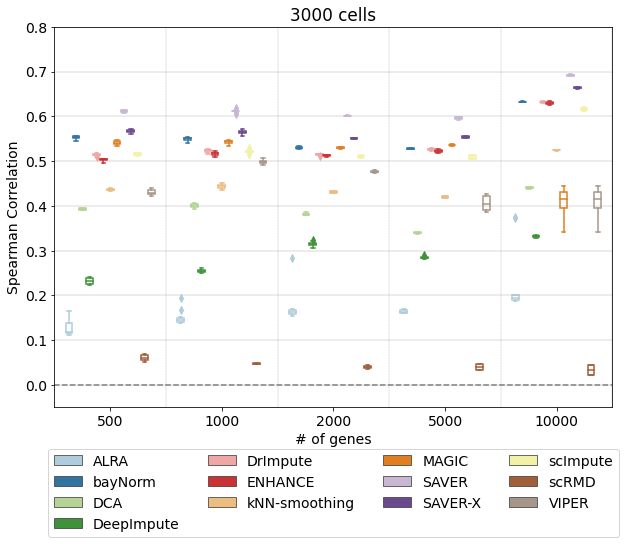

In [16]:
plt.rcParams.update({'font.size': 14})
nc = [100,3000]
pal = sns.color_palette('Paired', 12)
pal = list(pal) + [(171/255,149/255,132/255)]

for n in nc:
    fig, ax1 = plt.subplots(1,1,figsize=(10, 7))

    corr_zeros = df_corr[df_corr['algorithm'] != 'before denoising']
    sns.boxplot(x = "n_genes", 
                y="cell-cell correlation (zeros)", 
                hue = "algorithm", 
                data=corr_zeros[corr_zeros['n_cells'] == n], 
                hue_order=denoisers,
                ax=ax1,
               palette=pal)
    L = ax1.legend(loc=9, ncol=4, bbox_to_anchor=(0.5, -0.09))
    ax1.axhline(y=0, color="grey", linestyle="--")
    ax1.set_title(f"{n} cells")
    ax1.set_xlabel("# of genes")
    ax1.set_ylabel("Spearman Correlation")
    ax1.set_ylim(top=0.8, bottom = -0.05)

    for x in np.arange(0.5, 5):
        ax1.axvline(x=x, color="grey", linestyle="--", linewidth=0.3)

    for i,artist in enumerate(ax1.artists):
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        for j in range(i*6,i*6+6):
            line = ax1.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)
    # Rename labels in legend
    for i,d in enumerate(labels_den):
        L.get_texts()[i].set_text(d)
        
    plt.grid(True, axis='y', color='grey', linewidth=0.3)
    plt.show()
